## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from khan_helpers import Experiment
from khan_helpers.constants import FIG_DIR

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

## Set plotting params

In [306]:
plt.rcParams['pdf.fonttype'] = 42
sns.set_context('talk')
sns.set_style('white')
cmap = 'rocket_r'

## Define functions

In [5]:
def fmt_stats(data, other=None):
    """computes and formats r- and p-values for display in heatmap"""
    if other is None:
        other = data
    cols = data.columns
    cols_other = other.columns
    stats = np.empty((len(cols), len(cols_other)), dtype=object)
    for x, colx in enumerate(cols_other):
        for y, coly in enumerate(cols):
            r, p = pearsonr(other[colx], data[coly])
            r = f'= {r:.2f}'
            if p < 0.01:
                p = '< 0.01'
            else:
                p = f'= {p:.2f}'
            stats[x, y] = f'r {r}\np {p}'
    return stats

## Load & format data

In [6]:
exp = Experiment()
participants = exp.load_participants()

In [7]:
pix = pd.IndexSlice

prop_correct = pd.DataFrame(
    index=pd.MultiIndex.from_product((
        (f'qset{i}' for i in range(1, 4)), 
        (str(p) for p in participants))),
    columns=('General\nknowledge', 'Four\nForces', 'Birth of\nStars'),
    dtype=np.float
)

for p in participants:
    p_data = p.get_data()
    acc_grp = p_data.groupby(['lecture', 'qset'])['accuracy']
    p_acc = acc_grp.agg(lambda x: x.sum() / x.shape[0])
    prop_correct.loc[pix[:, str(p)], :] = p_acc.values.reshape(3, 3).T
    
prop_correct = prop_correct.reindex(
    columns=['General\nknowledge', 'Birth of\nStars', 'Four\nForces']
)
prop_correct.head()

General\nknowledge  Birth of\nStars  Four\nForces
qset1 P1            0.333333              0.6           0.6
      P2            0.333333              0.2           0.2
      P3            0.333333              0.2           0.6
      P4            0.666667              0.4           0.4
      P5            0.333333              0.4           0.2

## Relationships among proportion correct measures

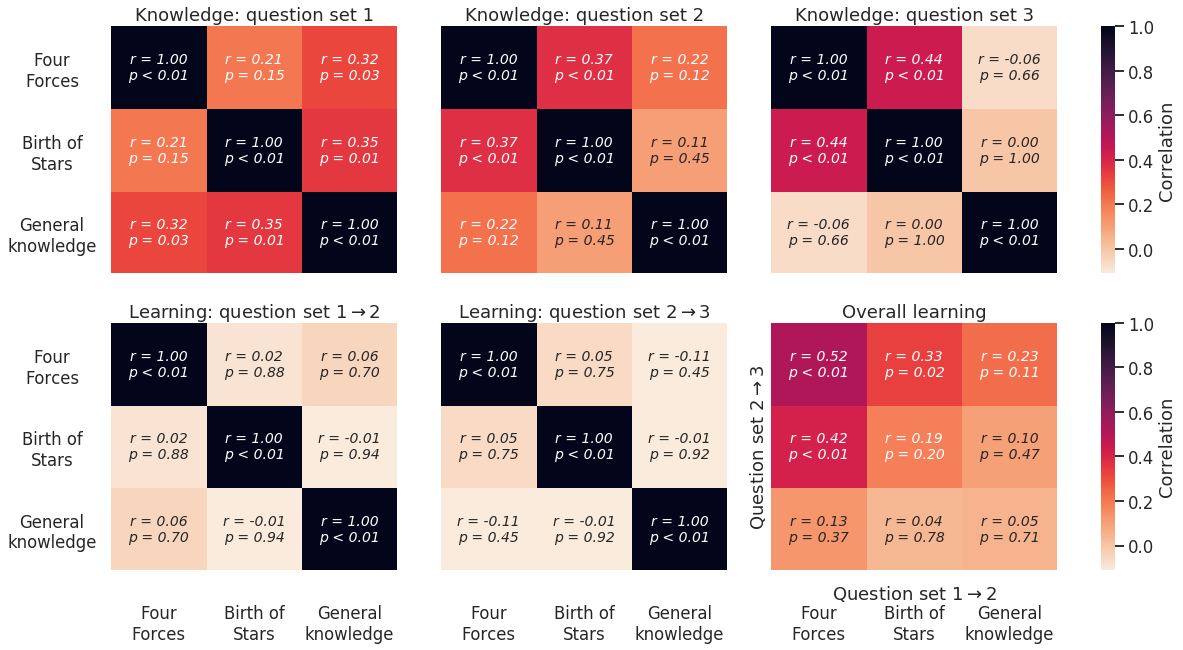

In [8]:
fig, axarr = plt.subplots(2, 4, figsize=(18, 10), 
                         gridspec_kw={'width_ratios': (1, 1, 1, .05)})
axarr, (cax1, cax2) = axarr[:, :3], axarr[:, 3]
cbar_kws = {'label': 'Correlation'}

for qset, ax in enumerate(axarr[0], start=1):
    cbar = True if qset == 3 else False
    cbar_ax = cax1 if cbar else None
    ckws = cbar_kws if cbar else None
    data = prop_correct.loc[f'qset{qset}']
    stats = fmt_stats(data)
    sns.heatmap(data.corr(), vmin=-.11, vmax=1, cmap=cmap, cbar=cbar, 
                cbar_ax=cbar_ax, cbar_kws=ckws, annot=stats, fmt='', 
                annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
    ax.set_title(f'Knowledge: question set {qset}')
    if qset == 1:
        ax.set_xticklabels([])
        ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
        ax.tick_params(axis='y', direction='out', pad=50)
    else:
        ax.axis('off')
    
for qset, ax in enumerate(axarr[1, :2], start=1):
    data = prop_correct.loc[f'qset{qset + 1}'] - prop_correct.loc[f'qset{qset}']
    stats = fmt_stats(data)
    sns.heatmap(data.corr(), vmin=0, vmax=1, cmap=cmap, cbar=False, annot=stats,
                fmt='', annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
    ax.set_title(rf'Learning: question set {qset}$\rightarrow${qset + 1}')
    if qset == 1:
        ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
        ax.tick_params(axis='y', direction='out', pad=50)
    else:
        ax.set_yticklabels([])
    
ax = axarr[1, 2]
d1 = prop_correct.loc['qset2']
d2 = prop_correct.loc['qset3']
data = d1.apply(lambda x: d2.corrwith(x))
stats = fmt_stats(d1, d2)
sns.heatmap(data, vmin=-.11, vmax=1, cmap=cmap, cbar=True, cbar_ax=cax2, 
            cbar_kws=cbar_kws, annot=stats, fmt='', 
            annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
ax.set_title('Overall learning')
ax.set_xlabel(r'Question set 1$\rightarrow$2', labelpad=-60)
ax.set_ylabel(r'Question set 2$\rightarrow$3', labelpad=-10)
ax.set_yticklabels([])

# doesn't work if called in loops above... very weird ¯\_(ツ)_/¯
for ax in axarr.flatten():
    ax.invert_xaxis()
    ax.invert_yaxis()
for ax in axarr[1]:
    ax.tick_params(axis='x', pad=25)

# plt.savefig(FIG_DIR.joinpath('prop-correct-relationships.pdf'), bbox_inches='tight')
plt.show()

## Relationships between proportion correct and novel measures

# TODO: drop questions with digits only (can't be modeled)?

In [375]:
from scipy.stats import pearsonr
from khan_helpers.functions import corr_mean

In [394]:
def bin_participants(participants, n_bins=5, lecture=None, qset=None):
    """
    bin participants by the simple proportion of questions answered 
    correctly for a given question set
    """
    bins = np.linspace(0, 1, n_bins+1)
    bin_dict = {b: [] for b in bins[1:]}
    for p in participants:
        p_data = p.get_data(lecture=lecture, qset=qset)
        prop_correct = p_data['accuracy'].sum() / p_data.shape[0]
        bin_ix = np.digitize(prop_correct, bins, right=True)
        bin_dict[bins[bin_ix]].append(p)
        
    return bin_dict

In [395]:
def compute_dispersion(participant, lecture=None, qset=None, normalize=True):
    p_data = participant.get_data(lecture=lecture, qset=qset)
    correct_qs = questions[p_data.loc[p_data['accuracy'] == 1, 'qID'] - 1]
    # avg topic vector for correctly answered questions
    avg_vec = correct_qs.mean(axis=0)
    # avg distance between avg topic vector and each question
    spread = corr_mean(cdist(np.atleast_2d(avg_vec), correct_qs, 'correlation').ravel(), axis=None)
    # optionally normalize by spread of *all* questions from block/about lecture
    if normalize:
        all_qs = questions[p_data['qID'] - 1]
        avg_all = all_qs.mean(axis=0)
        spread_all = corr_mean(cdist(np.atleast_2d(avg_all), all_qs, 'correlation').ravel(), axis=None)
    else:
        spread_all = 1
    
    return spread / spread_all

In [396]:
# get predictions for success with lecture 2 questions based on two metrics:
#  1. raw performance on lecture 1 questions
#  2. "dispersion" of knowledge based on lecture 1 success
props_correct = []
dispersion_scores = []
# also record *actual* lecture 2 question success
bos_acc = []
for p in participants:
    # get data for lecture 1-related questions answered immediately after viewing lecture 1
    p_data1 = p.get_data(lecture='forces', qset=1)
    props_correct.append((p_data1['accuracy'] == 1).sum() / 5)
    dispersion_scores.append(compute_dispersion(p, lecture=1, qset=1, normalize=True))
    p_data2 = p.get_data(lecture='bos', qset=2)
    bos_acc.append((p_data2['accuracy'] == 1).sum() / 5)

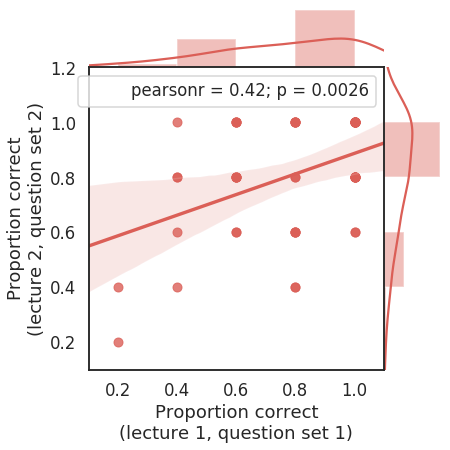

In [397]:
sns.jointplot(props_correct, bos_acc, kind='reg', space=0, stat_func=pearsonr)
plt.xlim(.1, 1.1)
plt.ylim(.1, 1.2)
plt.xlabel("Proportion correct\n(lecture 1, question set 1)")
plt.ylabel("Proportion correct\n(lecture 2, question set 2)")
plt.show()

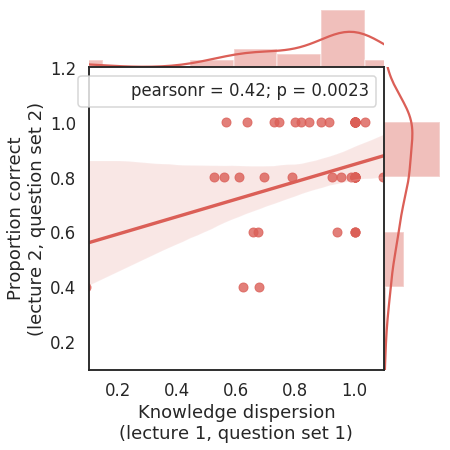

In [398]:
sns.jointplot(dispersion_scores, bos_acc, kind='reg', space=0, stat_func=pearsonr)
plt.xlim(.1, 1.1)
plt.ylim(.1, 1.2)
plt.xlabel("Knowledge dispersion\n(lecture 1, question set 1)")
plt.ylabel("Proportion correct\n(lecture 2, question set 2)")
plt.show()

In [366]:
# does weighting (lecture 1, qset 1) proportion correct by similarity to 
# given (lecture 2, qset 2) question improve prediction of whether it 
# will be answered correctly?
simple_prop_right = []
simple_prop_wrong = []
weighted_prop_right = []
weighted_prop_wrong = []

for p in participants:
    p_data1 = p.get_data(lecture='forces', qset=1)
    p_data2 = p.get_data(lecture='bos', qset=2)
    
    prop_correct = (p_data1['accuracy'] == 1).sum() / 5
    all_qvecs = questions[p_data1['qID'] - 1]
    correct_mask = p_data1['accuracy'] == 1
    
    for _, row in p_data2.iterrows():
        bos_qvec = questions[row['qID'] - 1]
        qcorrs = 1 - cdist(np.atleast_2d(bos_qvec), all_qvecs, 'correlation').ravel()
        weighted_prop = qcorrs[correct_mask].sum() / qcorrs.sum()
        if row['accuracy'] == 1:
            simple_prop_right.append(prop_correct)
            weighted_prop_right.append(weighted_prop)
        else:
            simple_prop_wrong.append(prop_correct)
            weighted_prop_wrong.append(weighted_prop)

In [371]:
np.mean(simple_prop_right), np.mean(simple_prop_wrong)

(0.7930000000000001, 0.6679999999999999)

In [370]:
np.mean(weighted_prop_right), np.mean(weighted_prop_wrong)

(0.5579998495757721, 0.7517919257795391)

In [372]:
from scipy.stats import ttest_ind

In [373]:
ttest_ind(simple_prop_right, simple_prop_wrong)

Ttest_indResult(statistic=3.4909157321243356, pvalue=0.0005696362469200698)

In [374]:
ttest_ind(weighted_prop_right, weighted_prop_wrong)

Ttest_indResult(statistic=-0.3701277022184448, pvalue=0.711603238712952)

# Scratch

In [60]:
p_data = p.get_data(lecture='forces', qset=1)

In [278]:
correct_qs = questions[p_data.loc[p_data['accuracy'] == 1, 'qID'] - 1]
avg_vec = correct_qs.mean(0)
avg_vec

array([0.19380812, 0.21454319, 0.09770114, 0.01513244, 0.07067403,
       0.22885998, 0.01513307, 0.01513314, 0.13388226, 0.01513262])

In [279]:
cdist(np.atleast_2d(avg_vec), correct_qs, 'correlation').mean()

0.545127882327798

In [65]:
((.5 + .7 + .3) / 3) / ((.5 + .5 + .3 + .7 + .4) / 5)

1.0416666666666667

In [243]:
class Participant:
    def __init__(self, shown_vecs, correct):
        self.shown_vecs = shown_vecs
        self.correct = np.array(correct)
        
    @property
    def dispersion(self):
        correct_spread = self._calc_spread(correct_only=True)
#         all_spread = self._calc_spread(correct_only=False)
        return correct_spread #/ all_spread
        
    def _calc_spread(self, correct_only=False):
        q_vecs = self.shown_vecs
        if correct_only:
            q_vecs = q_vecs[self.correct]
            
        avg_vec = q_vecs.mean(axis=0)
        spread = cdist(np.atleast_2d(avg_vec), q_vecs, 'correlation').mean()
        return spread

In [244]:
sets = []
set_dists = []
for i, q in enumerate(questions[:15]):
    dist_to_others = cdist(np.atleast_2d(q), np.delete(questions[:15], i, axis=0), 'correlation').ravel()
    closest_qs = dist_to_others.argsort()[:4]
    furthest_qs = dist_to_others.argsort()[-4:]
    sets.append((i, list(closest_qs)))
    sets.append((i, list(furthest_qs)))
    set_dists.append(dist_to_others[closest_qs].mean())
    set_dists.append(dist_to_others[furthest_qs].mean())
    
print(sets[np.argmin(set_dists)])
print(sets[np.argmax(set_dists)])

(10, [4, 3, 8, 2])
(6, [6, 13, 2, 3])


In [250]:
# p1_shown_vecs = questions[[18, 29, 33, 31, 38]]
# p2_shown_vecs = questions[[3, 6, 16, 19, 26]]
p1_shown_vecs = questions[[2, 3, 4, 8, 10]]
p2_shown_vecs = questions[[2, 3, 6, 7, 13]]
correct_ans = [True, True, True, True, False]

# correctly answers 4/5 similar questions
P1 = Participant(p1_shown_vecs, correct_ans)
# correctly answers 4/5 far apart questions
P2 = Participant(p2_shown_vecs, correct_ans)

print(f"P1 dispersion: {P1.dispersion}")
print(f"P2 dispersion: {P2.dispersion}")

P1 dispersion: 0.13903680433599463
P2 dispersion: 0.5874665677921396


In [235]:
test = np.array([1, 200, 3000, 40000])

for ix, n in enumerate(test):
    others = np.delete(test, ix, axis=0)
    print(sorted([n] + list(others)))

[1, 200, 3000, 40000]
[1, 200, 3000, 40000]
[1, 200, 3000, 40000]
[1, 200, 3000, 40000]


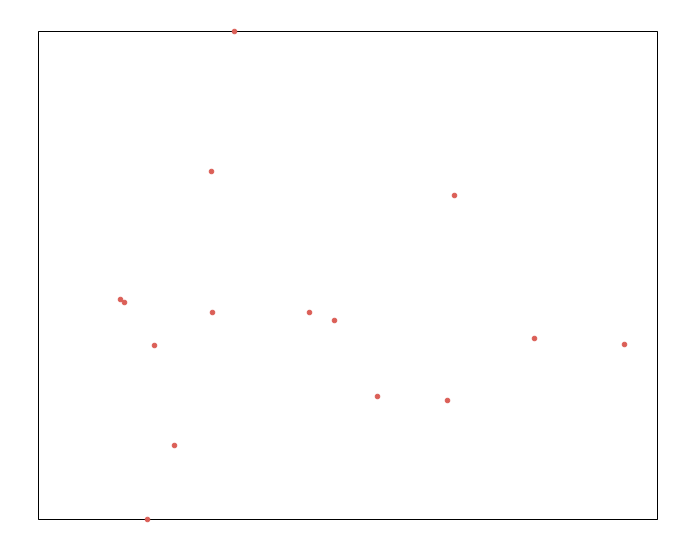

In [255]:
hyp.plot(questions[:15], fmt='.', size=(10, 8), ndims=2)

## Other ideas

In [ ]:
naive_incorrect = []
naive_correct = []
aware_incorrect = []
aware_correcrt = []
# for each participant
for p in participants:
    # for each question set
    for qset in range(3):
        # get data for that question set
        qset_data = p.get_data(qset=qset)
        # for each question in that qset
        for ix, row in qset_data.iterrows():
            
        # leave out one of the 13 questions
        
        # "naive" probability of getting it right is their proportion correct of other 12
        
        # "aware" probability of getting it right is weighted proportion based on 
        # correlation between not held out qs
        

In [9]:
# # get question IDs for question seen
# qset_qids = qset_data['qID'].values
# # get accuracy for those questions
# qset_acc = qset_data['accuracy'].values

# # Not really useful...
# pix = pd.IndexSlice

# mean_traces = pd.DataFrame(
#     index=prop_correct.index,
#     columns=('Four\nForces', 'Birth of\nStars'),
#     dtype=np.float
# )

# col_map = {'forces': 'Four\nForces', 'bos':'Birth of\nStars'}
# for p in participants:
#     for lecture in ('forces', 'bos'):
#         for qset in range(3):
#             p_trace = p.get_trace(f'{lecture}_qset{qset}')
#             mean_traces.loc[
#                 (f'qset{qset + 1}', str(p)), col_map[lecture]
#             ] = p_trace.mean()
    
# mean_traces = mean_traces.reindex(columns=['Birth of\nStars', 'Four\nForces'])
# mean_traces.head()

In [10]:
# # Not really useful...
# fig, axes = plt.subplots(2, 4, figsize=(18, 10), 
#                          gridspec_kw={'width_ratios': (1, 1, 1, .05)})
# axarr, (cax1, cax2) = axes[:, :3], axes[:, 3]
# cbar_kws = {'label': 'Correlation'}

# for qset, ax in enumerate(axarr[0], start=1):
#     cbar = True if qset == 3 else False
#     cbar_ax = cax1 if cbar else None
#     ckws = cbar_kws if cbar else None
#     data = mean_traces.loc[f'qset{qset}']
#     stats = fmt_stats(data)
#     sns.heatmap(data.corr(), vmin=0, vmax=1, cmap=cmap, cbar=cbar, 
#                 cbar_ax=cbar_ax, cbar_kws=ckws, annot=stats, fmt='', 
#                 annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
#     ax.set_title(f'Reconstructed knowledge:\nquestion set {qset}')
#     if qset == 1:
#         ax.set_xticklabels([])
#         ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
#         ax.tick_params(axis='y', direction='out', pad=50)
#     else:
#         ax.axis('off')
    
# for qset, ax in enumerate(axarr[1, :2], start=1):
#     data = mean_traces.loc[f'qset{qset + 1}'] - mean_traces.loc[f'qset{qset}']
#     stats = fmt_stats(data)
#     sns.heatmap(data.corr(), vmin=0, vmax=1, cmap=cmap, cbar=False, annot=stats,
#                 fmt='', annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
#     ax.set_title('Reconstructed learning:\n' + 
#                  rf'question set {qset}$\rightarrow${qset + 1}')
#     if qset == 1:
#         ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
#         ax.tick_params(axis='y', direction='out', pad=50)
#     else:
#         ax.set_yticklabels([])
    
# ax = axarr[1, 2]
# d1 = mean_traces.loc['qset2']
# d2 = mean_traces.loc['qset3']
# data = d1.apply(lambda x: d2.corrwith(x))
# stats = fmt_stats(d1, d2)
# sns.heatmap(data, vmin=0, vmax=1, cmap=cmap, cbar=True, cbar_ax=cax2, 
#             cbar_kws=cbar_kws, annot=stats, fmt='', 
#             annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
# ax.set_title('Overall reconstructed learning')
# ax.set_xlabel(r'Question set 1$\rightarrow$2', labelpad=-60)
# ax.set_ylabel(r'Question set 2$\rightarrow$3', labelpad=-10)
# ax.set_yticklabels([])

# # doesn't work if called in loops above... very weird ¯\_(ツ)_/¯
# for ax in axarr.flatten():
#     ax.invert_xaxis()
#     ax.invert_yaxis()
# for ax in axarr[1]:
#     ax.tick_params(axis='x', pad=25)

# # plt.savefig(FIG_DIR.joinpath('prop-correct-relationships.pdf'), bbox_inches='tight')
# plt.show()